In [1]:
import pandas as pd
from neural_priors.utils.data import get_all_subject_ids, Subject
import os.path as open
import os
import os.path as op

from tqdm.contrib.itertools import product
import seaborn as sns


ModuleNotFoundError: No module named 'neural_priors'

In [66]:
load_data_via_tsv = False
bids_folder = '/data/ds-neuralpriors'

if load_data_via_tsv:
    df = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t',
                    index_col=[0, 1, 2, 3, 4, 5,],
                    dtype={'subject':str})
    df.columns.name = 'parameter'
    df.index.set_names('voxel', level=-1, inplace=True)
else:
    df = []
    keys = []
    subjects = get_all_subject_ids()

    for subject, range_n, session, smoothed, gaussian in product(subjects, ['wide', 'narrow'], [None], [True], [True]):
    # for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None], [None], [True, False]):
        try:
            sub = Subject(subject, bids_folder)
            sub_df = sub.get_prf_parameters_volume(session=session, cross_validated=False, roi='NPCr', smoothed=smoothed, range_n=range_n, gaussian=gaussian)

            if gaussian:
                sub_df = sub_df.rename(columns={'mu':'mode', 'sd':'width'})
            else:
                sub_df = sub_df.rename(columns={'fwhm':'width'})
            df.append(sub_df)
            keys.append((subject,
                        range_n if range_n is not None else 'both', session if session is not None else 'both',
                        'smoothed' if smoothed else 'unsmoothed',
                        'gaussian' if gaussian else 'lognormal'))

        except Exception as e:
            print(f'Problem with {subject}: {e}')

    df = pd.concat(df, keys=keys, names=['subject', 'range_n', 'session', 'smoothed', 'model'])
    df.to_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t')

df = df.unstack(['range_n', 'model', ]).reorder_levels(axis='columns', order=['model', 'parameter', 'range_n'])
df = df.sort_index(axis=1, level=['model'], sort_remaining=False)

  0%|          | 0/78 [00:00<?, ?it/s]

In [67]:
df = df.droplevel(0, 1)

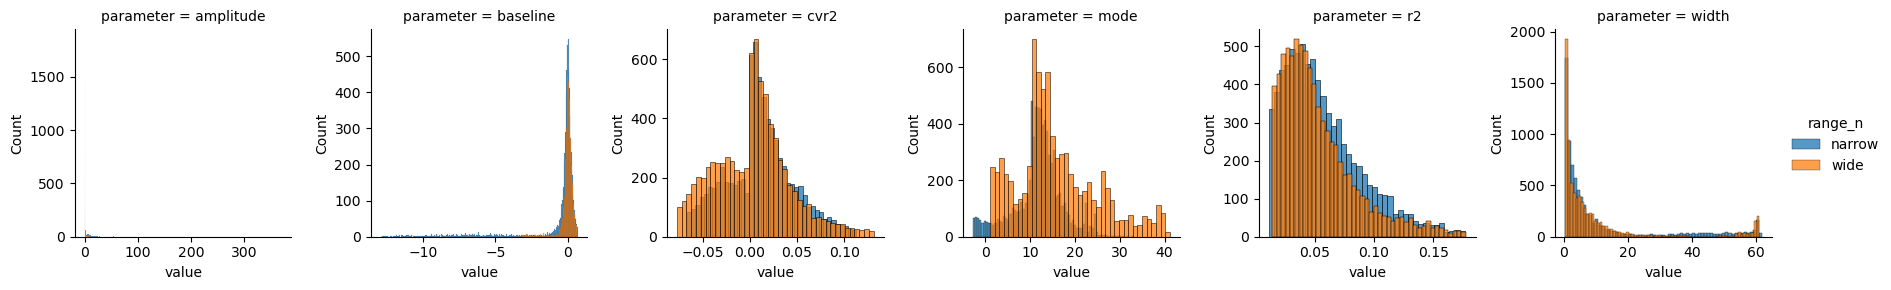

In [68]:
tmp = df[(df['cvr2'] > 0.0).any(axis=1)].stack([0, 1]).to_frame('value')

# Remove outliers for each parameters seperately
tmp = tmp.groupby(['parameter', 'range_n'], as_index=False).apply(lambda x: x[(x['value'] > x['value'].quantile(0.05)) & (x['value'] < x['value'].quantile(0.99))]).droplevel(0)


g = sns.FacetGrid(tmp.reset_index(), hue='range_n', col='parameter', sharex=False, sharey=False)
g.map(sns.histplot, 'value')
g.add_legend()

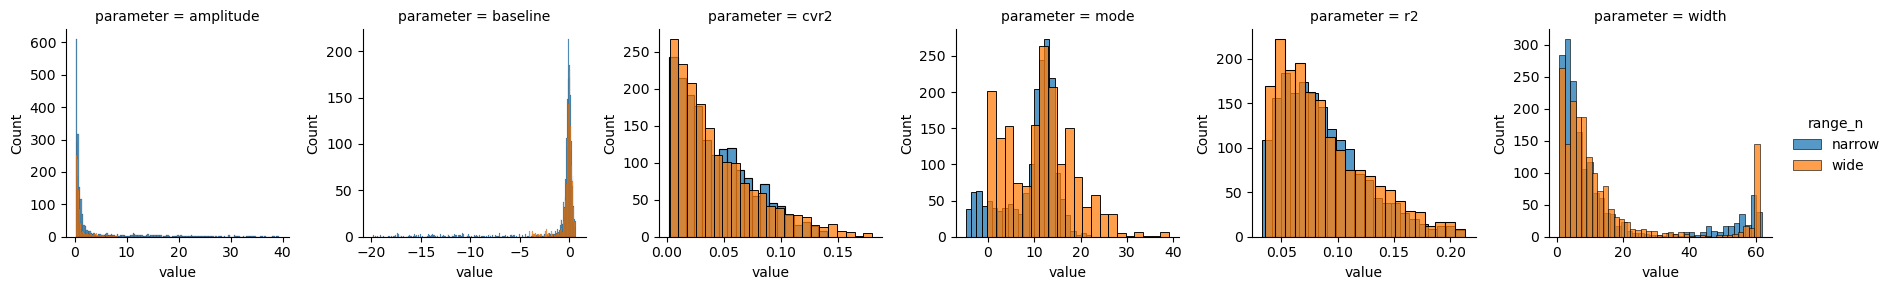

In [69]:
tmp = df[(df['cvr2'] > 0.0).all(axis=1)].stack([0, 1]).to_frame('value')

# Remove outliers for each parameters seperately
tmp = tmp.groupby(['parameter', 'range_n'], as_index=False).apply(lambda x: x[(x['value'] > x['value'].quantile(0.05)) & (x['value'] < x['value'].quantile(0.99))]).droplevel(0)


g = sns.FacetGrid(tmp.reset_index(), hue='range_n', col='parameter', sharex=False, sharey=False)
g.map(sns.histplot, 'value')
g.add_legend()

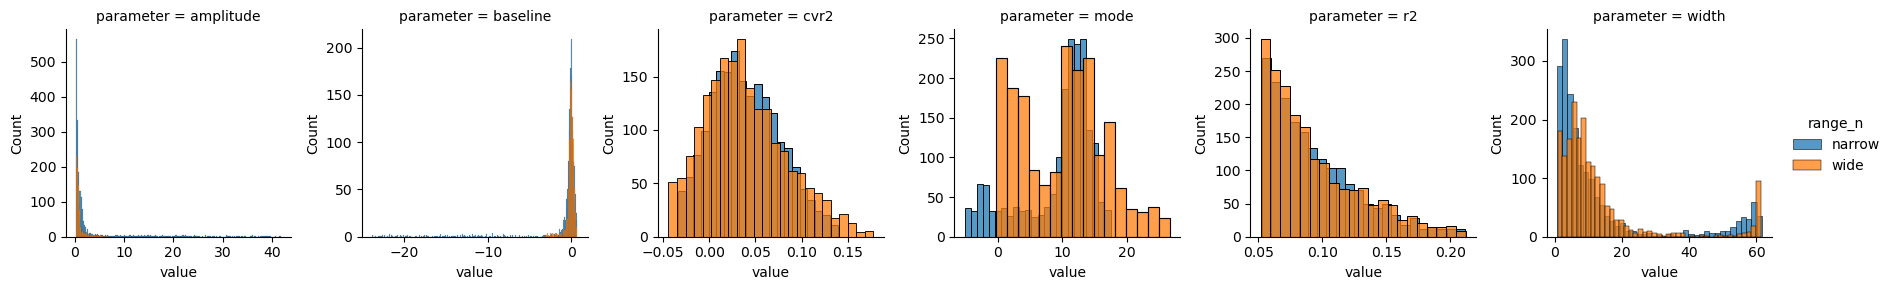

In [70]:
tmp = df[(df['r2'] > 0.05).all(axis=1)].stack([0, 1]).to_frame('value')

# Remove outliers for each parameters seperately
tmp = tmp.groupby(['parameter', 'range_n'], as_index=False).apply(lambda x: x[(x['value'] > x['value'].quantile(0.05)) & (x['value'] < x['value'].quantile(0.99))]).droplevel(0)


g = sns.FacetGrid(tmp.reset_index(), hue='range_n', col='parameter', sharex=False, sharey=False)
g.map(sns.histplot, 'value')
g.add_legend()

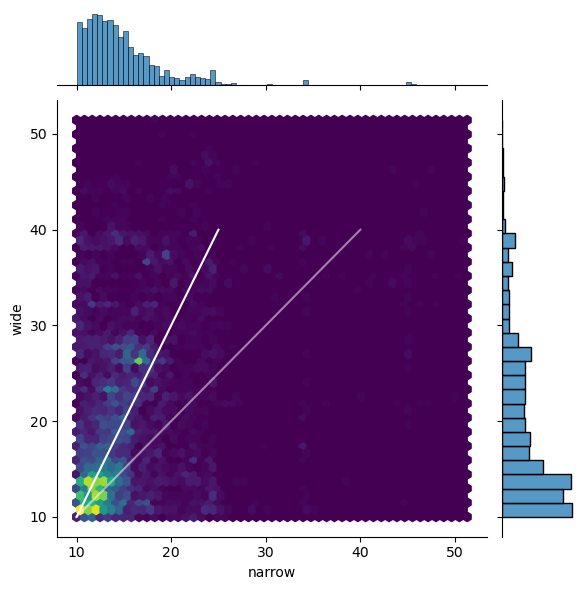

In [91]:
import matplotlib.pyplot as plt
tmp = df[(df['cvr2'] > 0.0).any(axis=1)]
tmp = tmp[tmp['mode'] > 10.]

sns.jointplot(x='narrow', y='wide', data=tmp['mode'].reset_index(), kind='hex', cmap='viridis', gridsize=50)

plt.plot([10, 40], [10, 40], c='white', alpha=.5)
plt.plot([10, 25], [10, 40], c='white')

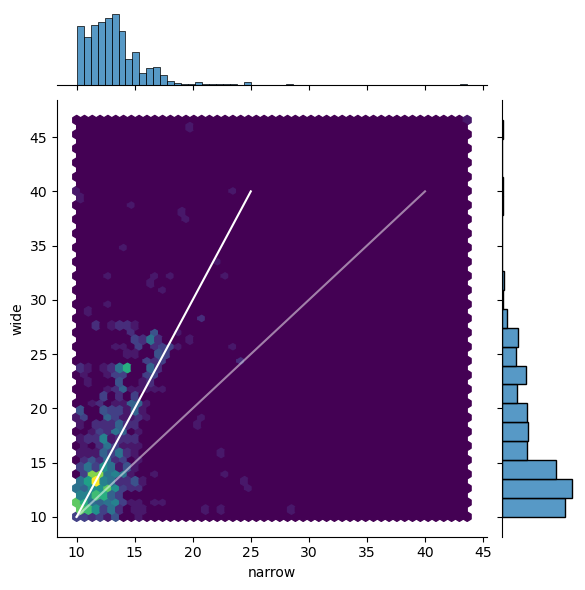

In [89]:
import matplotlib.pyplot as plt
tmp = df[(df['cvr2'] > 0.0).all(axis=1)]
tmp = tmp[tmp['mode'] > 10.]

sns.jointplot(x='narrow', y='wide', data=tmp['mode'].reset_index(), kind='hex', cmap='viridis', gridsize=50)

plt.plot([10, 40], [10, 40], c='white', alpha=.5)
plt.plot([10, 25], [10, 40], c='white')

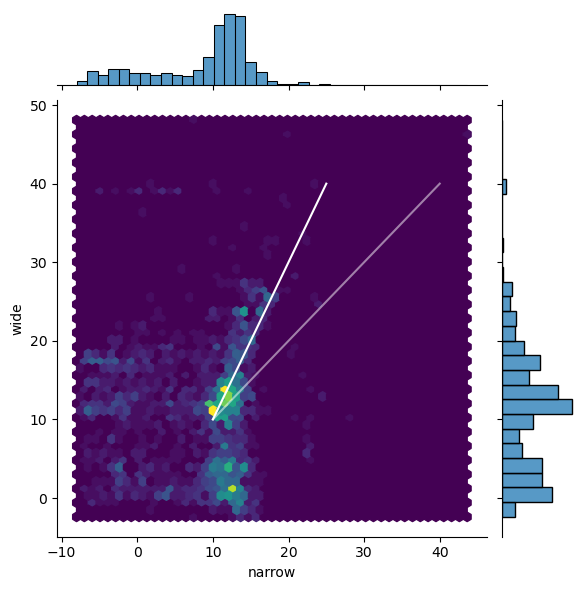

In [92]:
import matplotlib.pyplot as plt
tmp = df[(df['cvr2'] > 0.0).all(axis=1)]

sns.jointplot(x='narrow', y='wide', data=tmp['mode'].reset_index(), kind='hex', cmap='viridis', gridsize=50)

plt.plot([10, 40], [10, 40], c='white', alpha=.5)
plt.plot([10, 25], [10, 40], c='white')

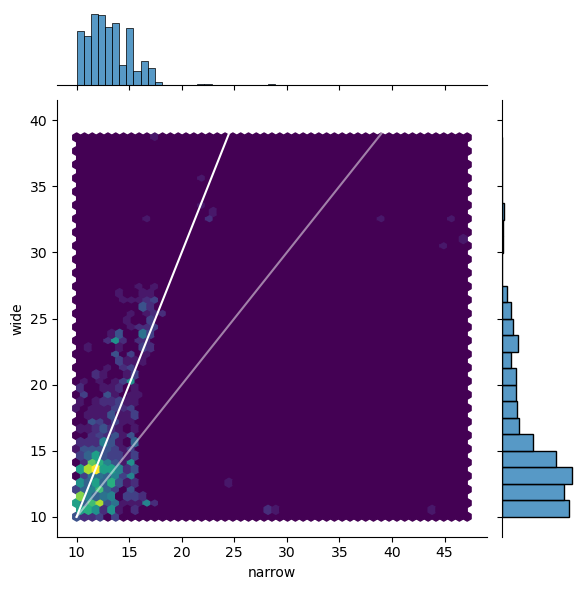

In [75]:
import matplotlib.pyplot as plt
tmp = df[(df['r2'] > 0.05).all(axis=1)]
tmp = tmp[tmp['mode'] > 10.]

sns.jointplot(x='narrow', y='wide', data=tmp['mode'].reset_index(), kind='hex', cmap='viridis', gridsize=50)

plt.plot([10, 40], [10, 40], c='white', alpha=.5)
plt.plot([10, 25], [10, 40], c='white')

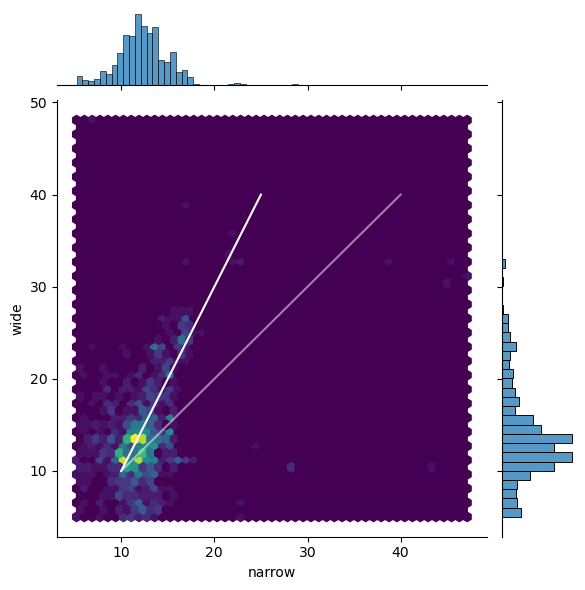

In [77]:
import matplotlib.pyplot as plt
tmp = df[(df['r2'] > 0.05).all(axis=1)]
tmp = tmp[tmp['mode'] > 5.]

sns.jointplot(x='narrow', y='wide', data=tmp['mode'].reset_index(), kind='hex', cmap='viridis', gridsize=50)

plt.plot([10, 40], [10, 40], c='white', alpha=.5)
plt.plot([10, 25], [10, 40], c='white')

In [81]:
tmp

parameter                          mode                 width             \
range_n                            wide     narrow       wide     narrow   
subject session smoothed                                                   
01      both    smoothed 71   13.699570  11.465857   3.134446   0.355029   
                         74   13.858201  11.457797   3.051085   0.321139   
                         105  13.646782  11.105591   3.384163  23.099789   
                         303        NaN  10.309849        NaN  49.149609   
                         305        NaN   7.232343        NaN  50.998981   
...                                 ...        ...        ...        ...   
41      both    smoothed 643   5.643405  14.251310  60.522255   3.861888   
                         644        NaN  13.497692        NaN   3.725685   
                         657   7.292040  12.794975   4.712531   4.029269   
                         665  10.463264  13.178851   3.967666   3.595969   
                         666        NaN  13.252144        NaN   3.597401   

parameter                    amplitude             baseline             \
range_n                           wide     narrow      wide     narrow   
subject session smoothed                                                 
01      both    smoothed 71   0.366547   1.129517 -0.165663  -0.094046   
                         74   0.330771   1.390817 -0.209722  -0.119509   
                         105  0.398055   2.625662 -0.252559  -2.576270   
                         303       NaN  13.862343       NaN -12.770686   
                         305       NaN   9.231359       NaN  -8.321330   
...                                ...        ...       ...        ...   
41      both    smoothed 643  2.129031   0.507482 -1.689000   0.034147   
                         644       NaN   0.429384       NaN   0.083743   
                         657  0.397136   0.283855  0.291540   0.209732   
                         665  0.273529   0.229526  0.223570   0.189012   
                         666       NaN   0.294461       NaN   0.187068   

parameter                           r2                cvr2            
range_n                           wide    narrow      wide    narrow  
subject session smoothed                                              
01      both    smoothed 71   0.056285  0.081474 -0.004127 -0.024380  
                         74   0.056979  0.082810  0.005364  0.009361  
                         105  0.058417  0.062829  0.012838 -0.003205  
                         303       NaN  0.111818       NaN  0.035631  
                         305       NaN  0.116141       NaN  0.064940  
...                                ...       ...       ...       ...  
41      both    smoothed 643  0.052723  0.145775 -0.020064  0.078236  
                         644       NaN  0.123752       NaN  0.084474  
                         657  0.050714  0.062907 -0.004034 -0.008371  
                         665  0.059913  0.056864  0.029861 -0.008017  
                         666       NaN  0.088222       NaN  0.018342  

[2057 rows x 12 columns]

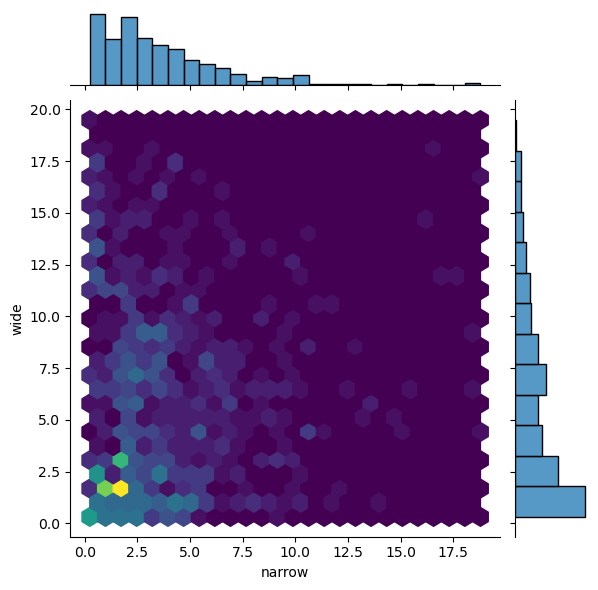

In [85]:
import matplotlib.pyplot as plt
tmp = df[(df['r2'] > 0.05).all(axis=1)]
tmp = tmp[tmp['mode'] > 5.]
tmp = tmp[tmp['width'] < 20.]

sns.jointplot(x='narrow', y='wide', data=tmp['width'].reset_index(), kind='hex', cmap='viridis', gridsize=25)

# plt.plot([10, 40], [10, 40], c='white', alpha=.5)
# plt.plot([10, 25], [10, 40], c='white')

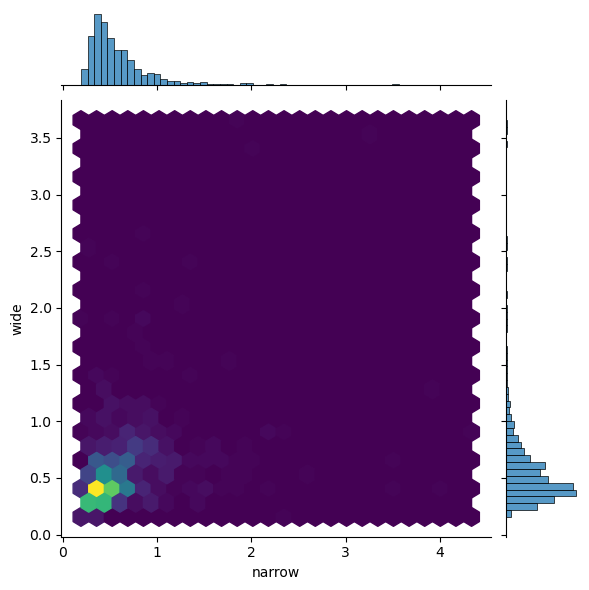

In [87]:
import matplotlib.pyplot as plt
tmp = df[(df['r2'] > 0.05).all(axis=1)]
tmp = tmp[tmp['mode'] > 5.]
tmp = tmp[tmp['width'] < 20.]
tmp = tmp[tmp['amplitude'] < 5.]

sns.jointplot(x='narrow', y='wide', data=tmp['amplitude'].reset_index(), kind='hex', cmap='viridis', gridsize=25)

# plt.plot([10, 40], [10, 40], c='white', alpha=.5)
# plt.plot([10, 25], [10, 40], c='white')

In [ ]:
sns.jointplot(data=df[(df['cvr2'] > 0.0).all(axis=1)].stack([0, 1]).reset_index(), x='width', y='mode', hue='range_n', kind='kde')